In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim  
import torchvision.transforms as transforms 
import torchvision
import os
import pandas as pd
from torch.utils.data import (Dataset,DataLoader) 
from skimage import io
import time
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
class veri(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
            
        return (image, y_label)

In [3]:
dataset = veri(csv_file = r"f113.csv",
              root_dir = r"f1_classification",
              transform = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

In [4]:
train_set,  test_set = torch.utils.data.random_split(dataset, [200,79]) 
train_loader = DataLoader(dataset=train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

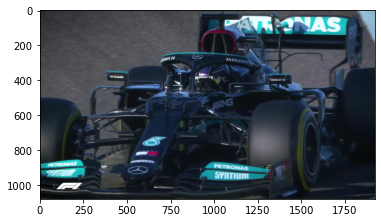

Mercedes
torch.Size([1, 3, 1080, 1920])


In [5]:
import matplotlib.pyplot as plt
import numpy as np
batch_size=1
classes=["Ferrari","Mclaren","Mercedes","Redbull"]

def imshow(img):
    img = img / 2 + 0.5   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
print(images.size())

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=4,kernel_size=(5,5))
        self.conv2=nn.Conv2d(in_channels=4,out_channels=8,kernel_size=(3,3))
        self.conv3=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(2,2))#22
        self.conv4=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(2,2))#10
        
        self.max=nn.MaxPool2d(kernel_size=(2,2))
        self.func=nn.ELU()
        
        self.fc1=nn.Linear(in_features=1001088,out_features=50)
        #self.fc1=nn.Linear(in_features=32*100*100,out_features=50)
        self.fc2=nn.Linear(in_features=50,out_features=50)
        self.fc3=nn.Linear(in_features=50,out_features=100)
        self.fc4=nn.Linear(in_features=100,out_features=4)
        
    def forward(self,x):
        
        x=self.conv1(x)
        x=self.func(x)
        
        x=self.max(x)
        
        x=self.conv2(x)
        x=self.func(x)
        
        x=self.max(x)
        
        x=self.conv3(x)
        x=self.func(x)
        
        x=self.max(x)
        
        x=self.conv4(x)
        x=self.func(x)

        #x=x.view(x.size(0), -1)
        x = x.view(x.size(0),1001088) 
        
        x=self.fc1(x)
        x=self.func(x)
        x=self.fc2(x)
        x=self.func(x)
        x=self.fc3(x)
        x=self.func(x)
        x=self.fc4(x)
        return x        

In [9]:
start=time.time()

device=torch.device("cuda")
model=Net()

optimizer=torch.optim.Adam(model.parameters(),lr=0.001)#0.00001 ilk
error=torch.nn.CrossEntropyLoss()

epoch=1
count = 0
loss_list = []
iteration_list = []
for i in range(epoch):
    for i,(images,label) in enumerate(train_loader):
        
        #images=images.to(device)
        #label=label.to(device)
        
        out=model(images)
        
        optimizer.zero_grad()
        
        loss=error(out,label)
        
        loss.backward()
        
        optimizer.step()  
        count+=1
        
        if count % 50 == 0:
            total=0
            correct=0
            correct_hata=0
            
            for images,labels in test_loader:
        
                out=model(images.float())
                
                y_pred=torch.max(out.data,1)[1]
                
                total+=len(labels)
                
                correct += (y_pred == labels).sum()
                correct_hata += (y_pred != labels).sum()
            
            accuracy = 100 * correct / float(total)
            hata = 100 * correct_hata / float(total)
            
            loss_list.append(loss.data)
            iteration_list.append(count)
        if count % 50 == 0:
            print('Iteration: {}  Loss: {}  Accuracy: {}% Error: {}%'.format(count, loss.data, accuracy,hata))

end=time.time()
print("Süre:",end-start)

Iteration: 50  Loss: 3.6711456775665283  Accuracy: 21.51898765563965% Error: 78.48101043701172%
Iteration: 100  Loss: 3.194270372390747  Accuracy: 39.24050521850586% Error: 60.75949478149414%
Iteration: 150  Loss: 2.185694932937622  Accuracy: 27.848100662231445% Error: 72.15190124511719%
Iteration: 200  Loss: 0.8988648056983948  Accuracy: 43.0379753112793% Error: 56.9620246887207%
Süre: 333.37694668769836


In [10]:
torch.save(model, "orijinal_model.pth")

In [11]:
def dogruluk(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            tahmin = model(x)
            _, pred = tahmin.max(1)
            num_correct += (pred==y).sum()
            num_samples += pred.size(0)
        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}")
        model.train()

In [12]:
print("Train Doğruluk: ")
dogruluk(train_loader, model)
print("Test Doğruluk: ")
dogruluk(test_loader, model)

Train Doğruluk: 
Got 81 / 200 with accuracy 40.50
Test Doğruluk: 
Got 34 / 79 with accuracy 43.04


In [13]:
from torchsummary import summary
summary(model, input_size=(3, 1080, 1920))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 4, 1076, 1916]             304
               ELU-2        [-1, 4, 1076, 1916]               0
         MaxPool2d-3          [-1, 4, 538, 958]               0
            Conv2d-4          [-1, 8, 536, 956]             296
               ELU-5          [-1, 8, 536, 956]               0
         MaxPool2d-6          [-1, 8, 268, 478]               0
            Conv2d-7         [-1, 16, 267, 477]             528
               ELU-8         [-1, 16, 267, 477]               0
         MaxPool2d-9         [-1, 16, 133, 238]               0
           Conv2d-10         [-1, 32, 132, 237]           2,080
              ELU-11         [-1, 32, 132, 237]               0
           Linear-12                   [-1, 50]      50,054,450
              ELU-13                   [-1, 50]               0
           Linear-14                   

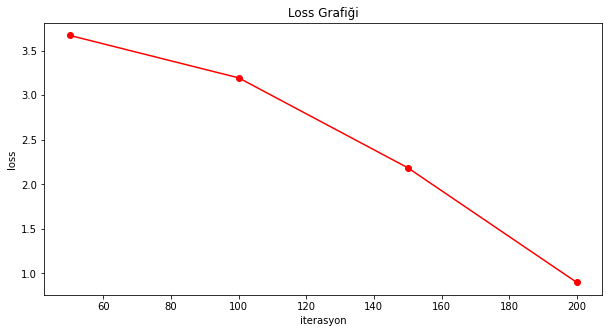

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 5))
plt.title("Loss Grafiği")
plt.plot(iteration_list, loss_list, "-o", color = "r")

plt.xlabel("iterasyon")
plt.ylabel("loss")
plt.show()

In [16]:
import numpy as np
clas_name = ["Ferrari", "Mclaren", "Mercedes", "Redbull"]
def imshow(img):
    img = img / 2 + 0.5   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def görselleştirme(model, image_sayısı = 6):
    was_training = model.training
    model.eval()
    resim_sayısı = 0
    with torch.no_grad():
        for image, labels in test_loader:
            
            output = model(image)
            _, tahmin = torch.max(output, 1)
            
            for j in range(image.size()[0]):
                plt.figure(figsize = (40, 30))
                resim_sayısı += 1
                ax = plt.subplot(image_sayısı // 2, 2, resim_sayısı)
                ax.axis("off")
                ax.set_title(f"Tahmin : {clas_name[tahmin[j]]}")
                imshow(image.cpu().data[j])
                
                if resim_sayısı == image_sayısı:
                    model.train(mode = was_training)
                    return

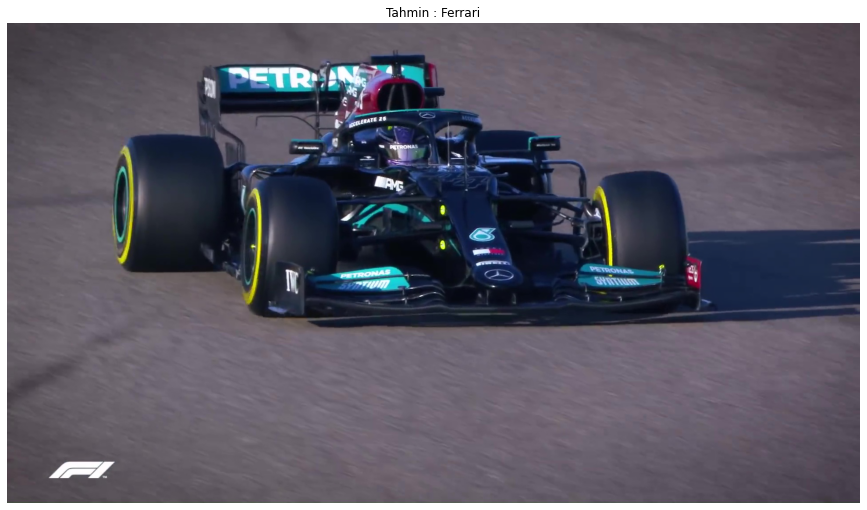

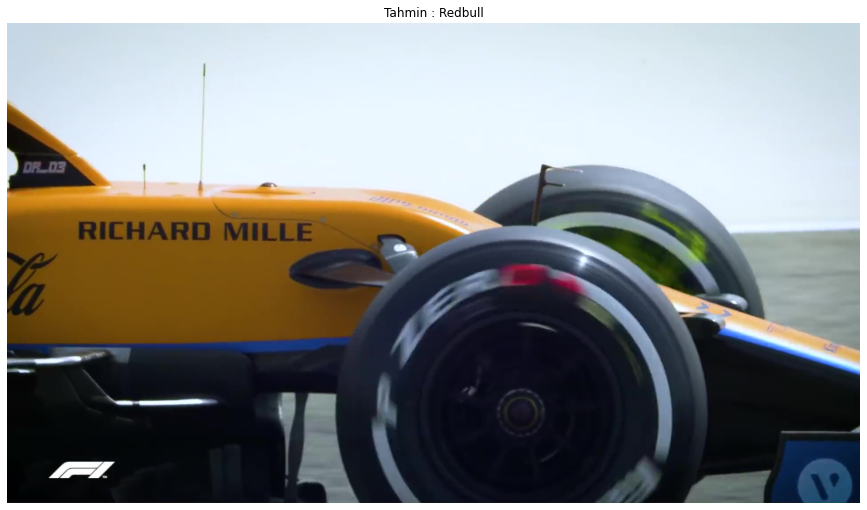

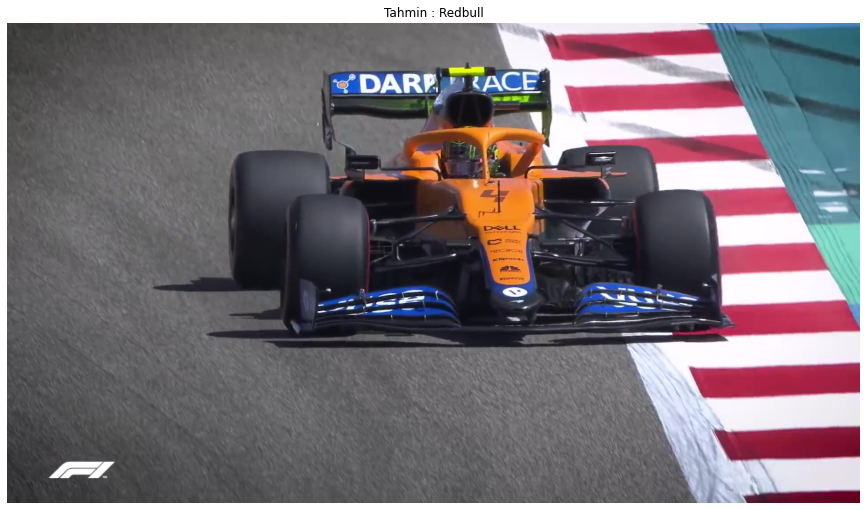

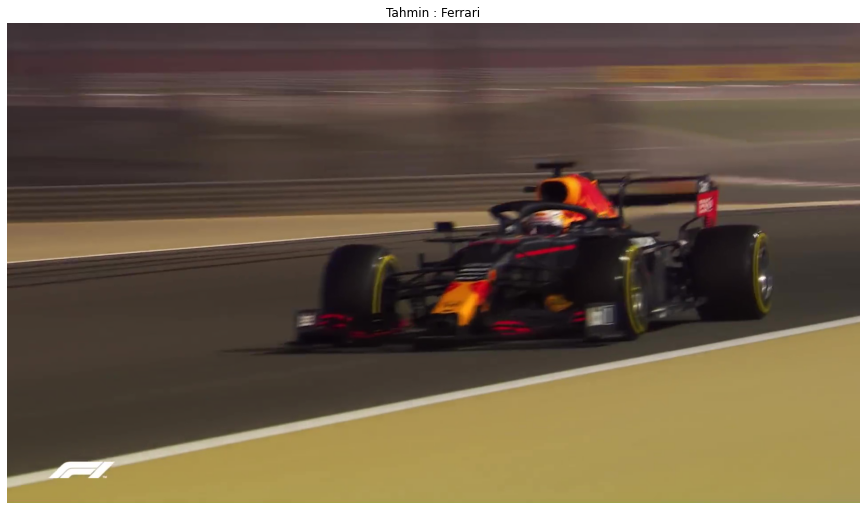

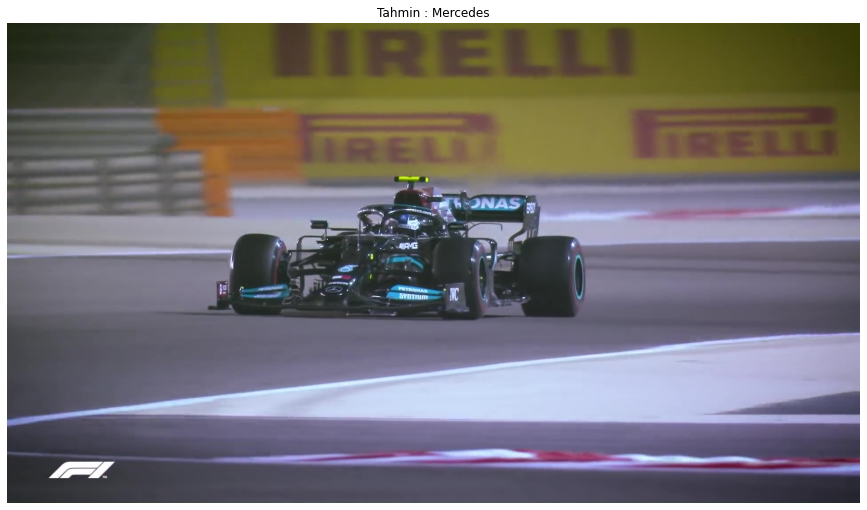

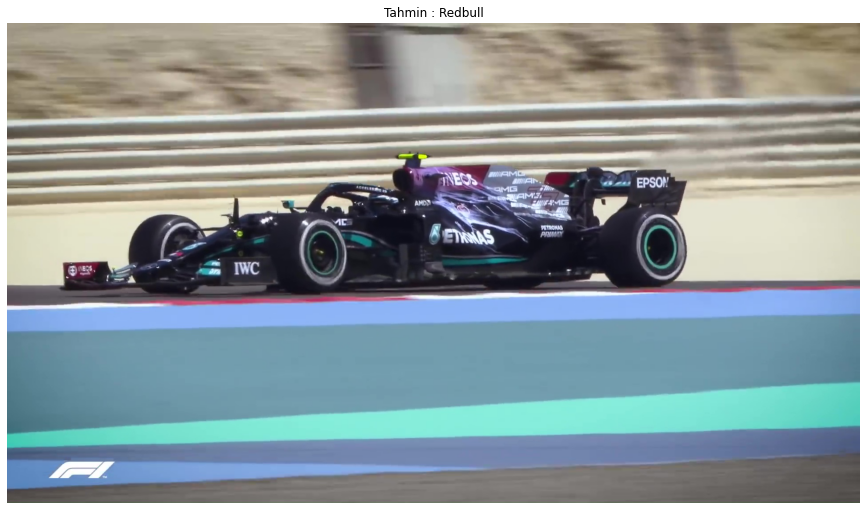

In [17]:
görselleştirme(model)